In [1]:

import findspark

findspark.init(spark_home='/Users/zhanghousu/spark/spark-3.3.1-bin-hadoop2',
                python_path='/Users/zhanghousu/conda/bin/python')

from pyspark import SparkContext
sc = SparkContext()
sc.addPyFile("jars/graphframes-0.8.2-spark2.4-s_2.11.jar")

                
from graphframes import *
from pyspark.sql.functions import *

23/04/30 00:11:34 WARN Utils: Your hostname, MacBook-Pro-279.local resolves to a loopback address: 127.0.0.1; using 192.168.1.17 instead (on interface en0)
23/04/30 00:11:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/30 00:11:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/30 00:11:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/04/30 00:11:36 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/04/30 00:11:36 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
23/04/30 00:11:36 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [2]:
links = sc.textFile('movie/links.csv')
ratings = sc.textFile('movie/ratings.csv')
movies_metadata = sc.textFile('movie/movies_metadata.csv')

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession(sc)
links_df = spark.read.csv(links, header=True, inferSchema=True, escape='"')
ratings_df = spark.read.csv(ratings, header=True, inferSchema=True, escape='"')
movies_metadata_df = spark.read.csv(movies_metadata, header=True, inferSchema=True, escape='"')

23/04/30 00:11:49 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2 (TID 3): Attempting to kill Python Worker


23/04/30 00:12:02 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 4 (TID 26): Attempting to kill Python Worker


In [4]:
ra_id_rating = ratings_df.select('userId', 'movieId', 'rating')
ra_id_rating.show(5)

23/04/30 00:12:07 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6 (TID 29): Attempting to kill Python Worker
+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|    110|   1.0|
|     1|    147|   4.5|
|     1|    858|   5.0|
|     1|   1221|   5.0|
|     1|   1246|   5.0|
+------+-------+------+
only showing top 5 rows



## This dataframe code will:

#### Create a GraphFrame using the ra_id_rating DataFrame.
#### Show the first 5 vertices and edges.
#### Calculate the in-degree and out-degree of each vertex.
#### Find the top 5 users who have rated the most movies.
#### Find the top 5 movies with the most ratings.

In [5]:
from graphframes import GraphFrame
from pyspark.sql.functions import col

# Prepare the vertices DataFrame
users_vertices = ra_id_rating.select("userId").distinct().withColumnRenamed("userId", "id")
movies_vertices = ra_id_rating.select("movieId").distinct().withColumnRenamed("movieId", "id")

vertices = users_vertices.union(movies_vertices)

# Prepare the edges DataFrame
edges = ra_id_rating.select("userId", "movieId", "rating").withColumnRenamed("userId", "src")\
                    .withColumnRenamed("movieId", "dst")

# Create a GraphFrame
graph = GraphFrame(vertices, edges)

# Show the vertices and edges
graph.vertices.show(5)
graph.edges.show(5)

# Calculate the in-degree of each vertex
in_degrees = graph.inDegrees
in_degrees.show(5)

# Calculate the out-degree of each vertex
out_degrees = graph.outDegrees
out_degrees.show(5)

# Find the top 5 users who have rated the most movies
top_raters = out_degrees.filter(col("id").isin(users_vertices.select("id").rdd.map(lambda row: row.id).collect()))\
                        .orderBy("outDegree", ascending=False)\
                        .limit(5)
top_raters.show()

# Find the top 5 movies with the most ratings
top_rated_movies = in_degrees.filter(col("id").isin(movies_vertices.select("id").rdd.map(lambda row: row.id).collect()))\
                             .orderBy("inDegree", ascending=False)\
                             .limit(5)
top_rated_movies.show()


/Users/zhanghousu/spark/spark-3.3.1-bin-hadoop2/python/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


+---+
| id|
+---+
|148|
|463|
|471|
|496|
|833|
+---+
only showing top 5 rows



23/04/30 00:12:34 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 12 (TID 75): Attempting to kill Python Worker
+---+----+------+
|src| dst|rating|
+---+----+------+
|  1| 110|   1.0|
|  1| 147|   4.5|
|  1| 858|   5.0|
|  1|1221|   5.0|
|  1|1246|   5.0|
+---+----+------+
only showing top 5 rows



/Users/zhanghousu/spark/spark-3.3.1-bin-hadoop2/python/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+-----+--------+
|   id|inDegree|
+-----+--------+
| 1645|   14346|
| 1591|    6317|
| 3175|   16216|
| 1580|   42193|
|68135|    2478|
+-----+--------+
only showing top 5 rows



+---+---------+
| id|outDegree|
+---+---------+
|148|       43|
|463|      261|
|471|      193|
|496|       10|
|833|        3|
+---+---------+
only showing top 5 rows



23/04/30 00:15:58 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/30 00:16:14 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/30 00:16:15 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


+------+---------+
|    id|outDegree|
+------+---------+
| 45811|    18276|
|  8659|     9279|
|270123|     7638|
|179792|     7515|
|228291|     7410|
+------+---------+



+----+--------+
|  id|inDegree|
+----+--------+
| 356|   91921|
| 318|   91082|
| 296|   87901|
| 593|   84078|
|2571|   77960|
+----+--------+



In [6]:
from graphframes import GraphFrame

# Prepare the vertices DataFrame
imdb_vertices = links_df.select("imdbId").distinct().withColumnRenamed("imdbId", "id")
tmdb_vertices = links_df.select("tmdbId").distinct().withColumnRenamed("tmdbId", "id")

vertices = imdb_vertices.union(tmdb_vertices)

# Prepare the edges DataFrame
edges = links_df.select("imdbId", "tmdbId").withColumnRenamed("imdbId", "src").withColumnRenamed("tmdbId", "dst")

# Create a GraphFrame
graph = GraphFrame(vertices, edges)

# Show the vertices and edges
graph.vertices.show(5)
graph.edges.show(5)

# Calculate the degree of each vertex
degrees = graph.degrees
degrees.show(5)


+------+
|    id|
+------+
|110081|
|109068|
|117500|
| 94265|
|106544|
+------+
only showing top 5 rows

+------+-----+
|   src|  dst|
+------+-----+
|114709|  862|
|113497| 8844|
|113228|15602|
|114885|31357|
|113041|11862|
+------+-----+
only showing top 5 rows

+------+------+
|    id|degree|
+------+------+
|110081|     1|
|109068|     1|
| 11858|     1|
| 36355|     1|
|117500|     2|
+------+------+
only showing top 5 rows



This result shows some basic information about the GraphFrame created using the links_df dataset. We can see that the vertices DataFrame is only showing the top 5 vertices, which includes the imdbId data. The edges DataFrame displays the top 5 mappings between imdbId and tmdbId, i.e., the source vertex (src) and the target vertex (dst).

Finally, we calculated the degree of each vertex, and here we are showing the top 5 vertices' degrees. The degree represents the number of edges related to the vertex. In this example, we can see that the degree varies between 1 and 2. This indicates that in our dataset, the association between most imdbId and tmdbId is relatively weak, with only a few imdbId being associated with multiple tmdbId.

In [7]:
%pip install networkx matplotlib


Note: you may need to restart the kernel to use updated packages.


In [8]:
movi_df = movies_metadata_df.select('id','genres')
movi_df.show(5)

23/04/30 00:17:16 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 42 (TID 233): Attempting to kill Python Worker
+-----+--------------------+
|   id|              genres|
+-----+--------------------+
|  862|[{'id': 16, 'name...|
| 8844|[{'id': 12, 'name...|
|15602|[{'id': 10749, 'n...|
|31357|[{'id': 35, 'name...|
|11862|[{'id': 35, 'name...|
+-----+--------------------+
only showing top 5 rows



In [9]:
movi_df = movi_df.withColumnRenamed("id", "movieId")
movi_df = movi_df.drop("id")
movi_df.show(5)

23/04/30 00:17:20 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 43 (TID 234): Attempting to kill Python Worker
+-------+--------------------+
|movieId|              genres|
+-------+--------------------+
|    862|[{'id': 16, 'name...|
|   8844|[{'id': 12, 'name...|
|  15602|[{'id': 10749, 'n...|
|  31357|[{'id': 35, 'name...|
|  11862|[{'id': 35, 'name...|
+-------+--------------------+
only showing top 5 rows



In [10]:
from pyspark.sql.functions import from_json, col, explode, \
    get_json_object, regexp_replace, array
from pyspark.sql.types import StructType, StructField, \
    StringType, IntegerType, ArrayType, MapType, DoubleType

json_schema = ArrayType(StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True)
]))

mv_ges = movi_df.withColumn('genres', regexp_replace("genres", 'None', "'None'"))
mv_ges = mv_ges.withColumn("genres_array", from_json(col("genres"), json_schema))

# explode
mv_ges = mv_ges.select(col("movieId"), explode(col("genres_array")).alias("genres_item"))

# extract
mv_ges_df = mv_ges.withColumn("genre_name", col("genres_item")["name"]) \
    .drop('genres_item')

mv_ges_df.show(5)

23/04/30 00:17:24 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 44 (TID 235): Attempting to kill Python Worker
+-------+----------+
|movieId|genre_name|
+-------+----------+
|    862| Animation|
|    862|    Comedy|
|    862|    Family|
|   8844| Adventure|
|   8844|   Fantasy|
+-------+----------+
only showing top 5 rows



In [11]:
ra_df = ratings_df.select('movieId','userId')
ra_df.show(5)

23/04/30 00:17:28 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 45 (TID 236): Attempting to kill Python Worker
+-------+------+
|movieId|userId|
+-------+------+
|    110|     1|
|    147|     1|
|    858|     1|
|   1221|     1|
|   1246|     1|
+-------+------+
only showing top 5 rows



In [12]:
# join two dataframe
joined_df = ra_df.join(mv_ges_df, on="movieId", how="inner")
joined_df.show(5)


+-------+------+----------+
|movieId|userId|genre_name|
+-------+------+----------+
|   1645|     4|  Thriller|
|   1645|     4|     Drama|
|   1645|     4|     Crime|
|   1591|     8|     Drama|
|   3175|     8|       War|
+-------+------+----------+
only showing top 5 rows



In [13]:
joined_df.count()

27741678

In [14]:
from pyspark.sql.functions import count, col

# count the number of users
total_users = joined_df.select("userId").distinct().count()

top_1_percent_users_count = int(total_users * 0.0002)

# count the number of ratings per user
user_ratings_count = joined_df.groupBy("userId").agg(count("movieId").alias("num_ratings"))

# sort by the number of ratings
sorted_users = user_ratings_count.sort(col("num_ratings").desc())

top_1_percent_users = sorted_users.limit(top_1_percent_users_count)

top_1_percent_users.show(5)


+------+-----------+
|userId|num_ratings|
+------+-----------+
| 45811|       7781|
|  8659|       7309|
|179792|       6247|
|107720|       5265|
|229879|       4782|
+------+-----------+
only showing top 5 rows



In [15]:
top_1_percent_users.count()

53

In [16]:
graph_df = top_1_percent_users.join(joined_df, on="userId", how="inner")
graph_df.show(5)

+------+-----------+-------+----------+
|userId|num_ratings|movieId|genre_name|
+------+-----------+-------+----------+
|  8659|       7309|    148|   Romance|
|  8659|       7309|    148|     Drama|
|  8659|       7309|    471|     Drama|
|  8659|       7309|    496|    Comedy|
|  8659|       7309|    833|     Drama|
+------+-----------+-------+----------+
only showing top 5 rows



In [17]:
graph_df.count()

192947

In [18]:
from pyspark.sql.functions import count, row_number
from pyspark.sql.window import Window

# count the number of movies per genre per user
genre_count_df = graph_df.groupBy("userId", "genre_name").agg(count("movieId").alias("genre_count"))

# sort by userId and genre_count in descending order
sorted_genres = genre_count_df.orderBy("userId", col("genre_count").desc())

# add a row number per userId
window_spec = Window.partitionBy("userId").orderBy(col("genre_count").desc())
row_num_df = sorted_genres.withColumn("row_number", row_number().over(window_spec))

# filter for the top 2 genres per user
top_5_genres_per_user = row_num_df.filter(col("row_number") <= 5)

top_5_genres_per_user.show()


+------+----------+-----------+----------+
|userId|genre_name|genre_count|row_number|
+------+----------+-----------+----------+
|  8659|     Drama|       1650|         1|
|  8659|    Comedy|        923|         2|
|  8659|  Thriller|        725|         3|
|  8659|    Action|        588|         4|
|  8659|   Romance|        571|         5|
| 24025|     Drama|        700|         1|
| 24025|    Comedy|        378|         2|
| 24025|  Thriller|        306|         3|
| 24025|    Action|        248|         4|
| 24025|   Romance|        228|         5|
| 32984|     Drama|        681|         1|
| 32984|    Comedy|        402|         2|
| 32984|  Thriller|        282|         3|
| 32984|   Romance|        236|         4|
| 32984|    Action|        231|         5|
| 33940|     Drama|        692|         1|
| 33940|    Comedy|        367|         2|
| 33940|  Thriller|        329|         3|
| 33940|   Romance|        256|         4|
| 33940|    Action|        246|         5|
+------+---

In [19]:
top_5_genres_per_user.count()

265

In [20]:
from graphframes import GraphFrame

# create the vertices DataFrame
users_vertices = top_5_genres_per_user.select("userId").distinct().withColumnRenamed("userId", "id")
genres_vertices = top_5_genres_per_user.select("genre_name").distinct().withColumnRenamed("genre_name", "id")

vertices = users_vertices.union(genres_vertices)

# create the edges DataFrame
edges = top_5_genres_per_user.select("userId", "genre_name")\
                              .withColumnRenamed("userId", "src")\
                              .withColumnRenamed("genre_name", "dst")

# create a GraphFrame
graph = GraphFrame(vertices, edges)

# show the vertices and edges
graph.vertices.show(5)
graph.edges.show(5)


+-----+
|   id|
+-----+
| 8659|
|24025|
|32984|
|33940|
|40207|
+-----+
only showing top 5 rows



+----+--------+
| src|     dst|
+----+--------+
|8659|   Drama|
|8659|  Comedy|
|8659|Thriller|
|8659|  Action|
|8659| Romance|
+----+--------+
only showing top 5 rows



/Users/zhanghousu/spark/spark-3.3.1-bin-hadoop2/python/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


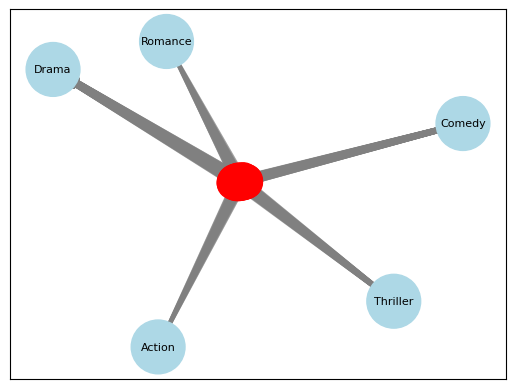

In [21]:
from graphframes import GraphFrame
import networkx as nx
import matplotlib.pyplot as plt

# create vertices DataFrame
distinct_users = top_5_genres_per_user.select("userId").distinct().withColumnRenamed("userId", "id")
distinct_genres = top_5_genres_per_user.select("genre_name").distinct().withColumnRenamed("genre_name", "id")
vertices = distinct_users.union(distinct_genres)

# create edges DataFrame
edges = top_5_genres_per_user.select("userId", "genre_name", "row_number").withColumnRenamed("userId", "src").withColumnRenamed("genre_name", "dst")

# create a GraphFrame
graph = GraphFrame(vertices, edges)

# show the vertices and edges
vertices_pd = graph.vertices.toPandas()
edges_pd = graph.edges.toPandas()

# create a directed graph
G = nx.from_pandas_edgelist(edges_pd, source='src', target='dst', edge_attr='row_number', create_using=nx.DiGraph())

# create a list of colors for nodes
colors = []
sizes = []
for node in G.nodes:
    if str(node).isdigit():
        colors.append('red')
        sizes.append(500)
    else:
        colors.append('lightblue')
        sizes.append(1500)

# plot the graph
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors)
nx.draw_networkx_edges(G, pos, width=[6 - G[u][v]['row_number'] for u, v in G.edges()], edge_color='gray', alpha=0.5)
labels = {genre: genre for genre in vertices_pd['id'] if not str(genre).isdigit()}
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color='black')
plt.show()
